
## dropout & Batch Normalization 

In [58]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [60]:
# 파라미터
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [61]:
# 데이터 가져오기
mnist_train = dsets.MNIST(root='./MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='./MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [62]:
# dataset loader
# 배치 사이즈(32)만큼 이미지 데이터들이 묶여있음
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [63]:
# nn layers
# 배치정규화
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

# 기본모델
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [64]:
# 모델 구현
# 드롭아웃, 배치 정규화 적용
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)

# 배치 정규화 미적용
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [65]:
# cost, loss, optimizer 정의
criterion = torch.nn.CrossEntropyLoss().to(device) # 소프트맥스(출력층 활성화함수) 함수 내장
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [66]:
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

for epoch in range(training_epochs):
    bn_model.train() # set the model to train mode. dropout = True

    for X, Y in train_loader:
        # reshape. 한 이미지에는 784개의 픽셀이 존재
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        # 배치 정규화 적용 모델
        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        # 기본 모델
        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval() # set the model to evaluation mode, dropout = False

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader): # 1875개의 배치묶음
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y) # 각 배치묶음별  평균 loss 저장
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y) # 각 배치묶음별  평균 loss 저장
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print('=============================== EPOCH %d ===============================' %(epoch+1))
        print('[Train] Batchnorm Loss:%.5f(Acc:%.2f) | No Batchnorm Loss:%.5f(Acc:%.2f)' %(bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader): # 1875개의 배치묶음
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y) # 각 배치묶음별  평균 loss 저장
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y) # 각 배치묶음별  평균 loss 저장
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print('[Valid] Batchnorm Loss:%.5f(Acc:%.2f) | No Batchnorm Loss:%.5f(Acc:%.2f)' % (bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('finished')

=============================== EPOCH 1 ===============================
[Train] Batchnorm Loss:0.13417(Acc:0.96) | No Batchnorm Loss:0.17999(Acc:0.95)
[Valid] Batchnorm Loss:0.14449(Acc:0.95) | No Batchnorm Loss:0.19982(Acc:0.94)

=============================== EPOCH 2 ===============================
[Train] Batchnorm Loss:0.11309(Acc:0.96) | No Batchnorm Loss:0.20659(Acc:0.94)
[Valid] Batchnorm Loss:0.12857(Acc:0.96) | No Batchnorm Loss:0.22705(Acc:0.94)

=============================== EPOCH 3 ===============================
[Train] Batchnorm Loss:0.09239(Acc:0.97) | No Batchnorm Loss:0.14868(Acc:0.96)
[Valid] Batchnorm Loss:0.11688(Acc:0.97) | No Batchnorm Loss:0.18302(Acc:0.95)

=============================== EPOCH 4 ===============================
[Train] Batchnorm Loss:0.08073(Acc:0.97) | No Batchnorm Loss:0.15767(Acc:0.96)
[Valid] Batchnorm Loss:0.10899(Acc:0.97) | No Batchnorm Loss:0.20203(Acc:0.95)

=============================== EPOCH 5 ===============================
[Tra

In [67]:
# plotting
import matplotlib.pylab as plt
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(6,5))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

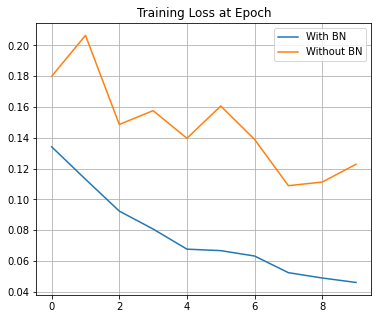

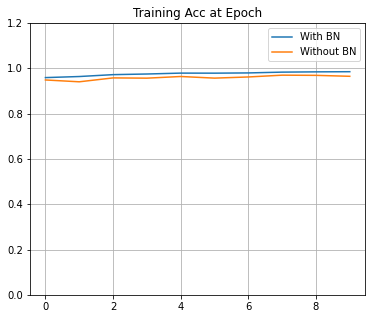

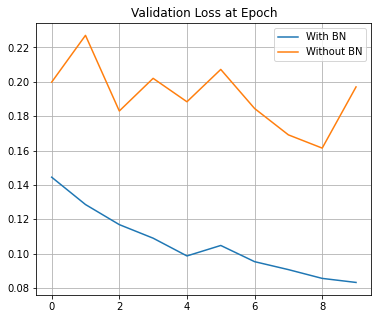

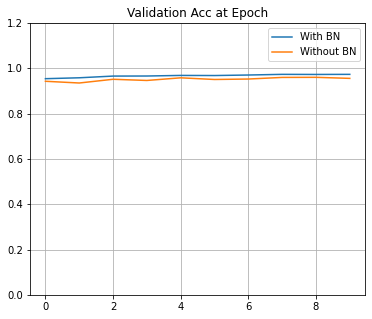

In [68]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.2], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.2], title='Validation Acc at Epoch')